## Imports

In [ ]:
%%capture
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import seaborn as sns
from functools import partial
from tqdm import trange
from ipywidgets import interact

try:
    import optax
except ModuleNotFoundError:
    %pip install optax
    import optax

try:
    import jax
except ModuleNotFoundError:
    %pip install jaxlib jax
    import jax
import jax.numpy as jnp

try:
    import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
    %pip install tensorflow-probability
    import tensorflow_probability.substrates.jax as tfp

## JAX

* A lower level ML library deveoped by Google
* Numpy on GPU, TPU
* Functional approach (pure functions, please!)

### Hello World

In [ ]:
lst = [1.0, 2.0, 3.0]

In [ ]:
array = jnp.array(lst)
array

DeviceArray([1., 2., 3.], dtype=float32)

In [ ]:
array.shape, array.dtype

((3,), dtype('float32'))

In [ ]:
array.device()

CpuDevice(id=0)

In [ ]:
array.tolist()

[1.0, 2.0, 3.0]

### Random number sampling

In [ ]:
np.random.seed(0)
np.random.uniform(), np.random.uniform(), np.random.uniform()

(0.5488135039273248, 0.7151893663724195, 0.6027633760716439)

In [ ]:
np.random.uniform()

0.5448831829968969

In [ ]:
key = jax.random.PRNGKey(0)
jax.random.uniform(key), jax.random.uniform(key), jax.random.uniform(key)

(DeviceArray(0.41845703, dtype=float32),
 DeviceArray(0.41845703, dtype=float32),
 DeviceArray(0.41845703, dtype=float32))

In [ ]:
jax.random.uniform(key)

DeviceArray(0.41845703, dtype=float32)

In [ ]:
jax.random.uniform(key, shape=(10,), minval=-5, maxval=5)

DeviceArray([-1.4509487 ,  1.0419903 , -0.72415733, -2.6938403 ,
             -1.7014146 , -0.6046343 , -2.4900234 , -2.2269428 ,
              2.6782074 ,  2.1474562 ], dtype=float32)

In [ ]:
# jax.random.normal(key, shape=10)  # This will not work because shape must be an iterable
jax.random.normal(key, shape=(10,))

DeviceArray([-0.3721109 ,  0.26423115, -0.18252768, -0.7368197 ,
             -0.44030377, -0.1521442 , -0.67135346, -0.5908641 ,
              0.73168886,  0.5673026 ], dtype=float32)

### Question: Can you generate samples with a specified mean and standard deviation?

$$
x \sim \mathcal{N}(\mu, \sigma)
$$

In [ ]:
#@title Answer
def normal(key, shape, mu=0, sigma=1):
  sample = jax.random.normal(key, shape)
  return mu + sample * sigma

samples = normal(key, shape=(10,), mu=3.0, sigma=1.0)
samples

DeviceArray([2.6278892, 3.2642312, 2.8174722, 2.2631803, 2.5596962,
             2.8478558, 2.3286467, 2.4091358, 3.731689 , 3.5673027],            dtype=float32)

### Basics of keys


In [ ]:
key = jax.random.PRNGKey(123)
key

DeviceArray([  0, 123], dtype=uint32)

In [ ]:
key = jnp.array([0, 0], dtype=jnp.uint32)
key

DeviceArray([0, 0], dtype=uint32)

In [ ]:
key.shape

(2,)

In [ ]:
keys = jax.random.split(key, num=10)
keys.shape

(10, 2)

### Caveat: one key should be used only once

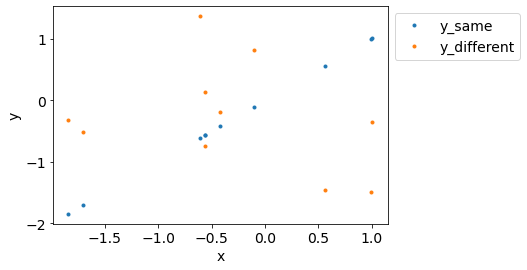

In [ ]:
key = jax.random.PRNGKey(123)
another_key = jax.random.PRNGKey(456)

x = jax.random.normal(key, shape=(10,))
y_same = jax.random.normal(key, shape=(10,))
y_different = jax.random.normal(another_key, shape=(10,))

plt.plot(x, y_same, '.', label='y_same')
plt.plot(x, y_different, '.', label='y_different')
plt.legend(bbox_to_anchor=(1,1));
plt.xlabel('x');plt.ylabel('y');

### JIT (Just In Time) function

In [ ]:
def math_function(x):
    x = jnp.sin(x)
    x = jnp.exp(x)
    x = jnp.square(x)
    x = jnp.log(x)
    x = jnp.dot(x, x.T)
    return x.sum()

In [ ]:
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (10**9, ))

math_function(x).block_until_ready()  # warm up
%timeit -n1 -r10 math_function(x).block_until_ready()

26.4 ms ± 164 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [ ]:
jitted_math_function = jax.jit(math_function)

jitted_math_function(x).block_until_ready()  # warm up
%timeit -n1 -r10 jitted_math_function(x).block_until_ready()

8.58 ms ± 15.5 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)


### Special notes on JIT

In [ ]:
# Be careful with global variables

def plus_x(y):
    return x+y

jitted_plus_x = jax.jit(plus_x)

print(jitted_plus_x)
x = 0
print(jitted_plus_x(2))
x = 5
print(jitted_plus_x(2))
jitted_plus_x = jax.jit(plus_x)
print(jitted_plus_x(2))

<CompiledFunction of <function plus_x at 0x7fd1205434c0>>
2
2
2


In [ ]:
# Static arguments? mention explicitely
def sample(key, deterministic):
    if deterministic == "True":
        return jnp.array(0.0)
    else:
        return jax.random.normal(key)

In [ ]:
jitted_sample = jax.jit(sample, static_argnames=['deterministic'])
# jitted_sample = jax.jit(sample)

key = jax.random.PRNGKey(123)

deterministic = "True"
print(jitted_sample(key, deterministic))

deterministic = "False"
print(jitted_sample(key, deterministic))

0.0
-0.75307846


### vmap

$$
\boldsymbol{y} = X\boldsymbol{\theta}
$$

In [ ]:
def predict(x, theta):
    """
    x: (n, d)
    theta: (d, )
    """
    return jnp.dot(x, theta)

x = jax.random.normal(key, shape=(10, 5))
subkey = jax.random.split(key, num=1)[0]
theta = jax.random.normal(subkey, shape=(5,))

print(predict(x, theta))

[ 0.7046675  -0.29442528  2.4415731  -3.5003483  -2.835635    2.4002323
  3.6175876   3.0491467   6.2198896   0.02163917]


$$
y_i = x_1\theta_1 + x_2\theta_2 + ... = \sum_{j=1}^{d}x_{ij}\theta_j
$$

In [ ]:
def predict_single_example(x, theta):
    """
    x: (d, )
    theta: (d, )
    """
    return (x * theta).sum()

predict = jax.vmap(predict_single_example, in_axes=(0, None))

print(predict(x, theta))

[ 0.7046675  -0.29442528  2.4415731  -3.5003483  -2.835635    2.4002323
  3.6175876   3.0491467   6.2198896   0.02163917]


In [ ]:
def distance(x1, x2):
    return (x1 - x2) ** 2

x1_array = jnp.array([1, 2, 3])
x2_array = jnp.array([5, 6])

f1 = jax.vmap(distance, in_axes=(None, 0))
f2 = jax.vmap(f1, in_axes=(0, None))

f2(x1_array, x2_array)

DeviceArray([[16, 25],
             [ 9, 16],
             [ 4,  9]], dtype=int32)

## TFP

In [ ]:
tfd = tfp.distributions

### Distributions

In [ ]:
normal = tfd.Normal(loc=5.0, scale=1.0)
normal

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [ ]:
normal_batched = tfd.Normal(loc=5.0, scale=[1.0, 0.1, 3.0])
normal_batched.stddev()

DeviceArray([1. , 0.1, 3. ], dtype=float32)

In [ ]:
sample = normal.sample(sample_shape=(2,), seed=key)
sample

DeviceArray([4.969502 , 5.4928904], dtype=float32)

In [ ]:
normal.prob(sample)

DeviceArray([0.3004415], dtype=float32)

In [ ]:
normal.log_prob(sample)

DeviceArray([-1.2025021], dtype=float32)

In [ ]:
sample_batch = normal_batched.sample(sample_shape=(1,), seed=key)
sample_batch

DeviceArray([[4.8529673, 5.055248 , 9.945494 ]], dtype=float32)

In [ ]:
normal_batched.log_prob(sample_batch)

DeviceArray([[-0.9297478,  1.2310302, -3.3763235]], dtype=float32)

In [ ]:
tfd.Normal(loc=5.0, scale=1.0).log_prob(sample_batch[:, 0])

DeviceArray([-0.9297478], dtype=float32)

In [ ]:
support = jnp.linspace(0, 10, 100)

# plt.plot(support, normal.log_prob(support));
normal.prob(1), normal.prob(50), normal.prob(100)
normal.log_prob(1), normal.log_prob(50), normal.log_prob(100000)

(DeviceArray(-8.918939, dtype=float32),
 DeviceArray(-1013.41895, dtype=float32),
 DeviceArray(-4.9995e+09, dtype=float32))

### Multivariate Normal

In [ ]:
mvn_diag = tfd.MultivariateNormalDiag
mvn_low_rank = tfd.MultivariateNormalDiagPlusLowRank
mvn = tfd.MultivariateNormalFullCovariance

# Self-study

### Beta distribution

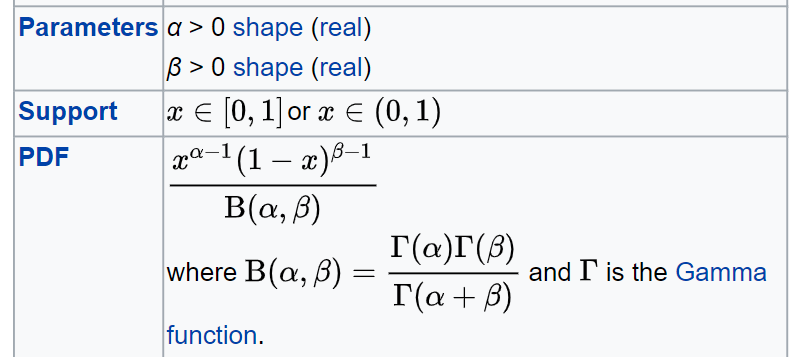

In [ ]:
support = jnp.linspace(0.01, 0.99, 100)

@interact(alpha=(0.1, 5000.0), beta=(0.1, 5000.0))
def plot_beta(alpha=1.0, beta=1.0):
    dist = tfd.Beta(alpha, beta)
    plt.plot(support, dist.prob(support))
    plt.xlabel('$x$')
    plt.ylabel('$p(x)$')

interactive(children=(FloatSlider(value=1.0, description='alpha', max=5000.0, min=0.1), FloatSlider(value=1.0,…

### Student-T distribution
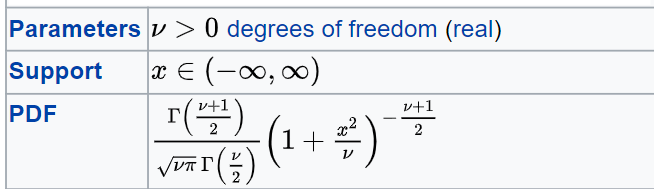

In [ ]:
@interact(df=(0.1, 10.0), loc=(0.1, 5.0), scale=(0.1, 5.0))
def plot_beta(df=1.0, loc=10.0, scale=1.0):
    support = jnp.linspace(loc-3*scale, loc+3*scale, 100)
    dist = tfd.StudentT(df=df, loc=loc, scale=scale)
    plt.plot(support, dist.prob(support))
    plt.xlabel('$x$')
    plt.ylabel('$p(x)$')

interactive(children=(FloatSlider(value=1.0, description='df', max=10.0, min=0.1), FloatSlider(value=5.0, desc…

### Self-study: Compare StudentT with Normal keeping same `loc` and `scale` in both. What do you observe?

### Self-study: `tfb = tfp.bijectors`

## Likelihood plotting

Likelihood: $p(\mathcal{D}/\boldsymbol{\theta})$

In [ ]:
theta = 0.3
bernoulli = tfd.Bernoulli(probs=theta)

In [ ]:
data = bernoulli.sample(sample_shape=(10,), seed=key)
data

DeviceArray([0, 1, 1, 1, 0, 0, 0, 0, 1, 1], dtype=int32)

In [ ]:
def prob(theta, data):
    dist = tfd.Bernoulli(probs=theta)
    prob = 1
    for i in range(len(data)):
        prob *= dist.prob(data[i])
    return prob

prob(theta=0.3, data=data)

DeviceArray(0.00040841, dtype=float32)

In [ ]:
theta = jnp.linspace(0.01, 0.99, 100)

vectorized_prob = jax.vmap(prob, in_axes=(0, None))
probs = vectorized_prob(theta, data)
probs.shape

(100,)

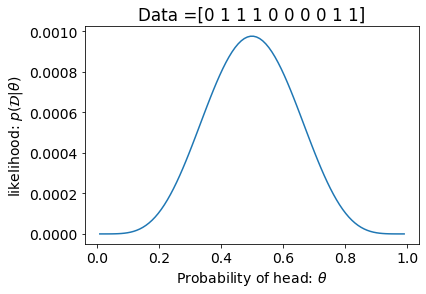

In [ ]:
plt.plot(theta, probs)
plt.xlabel(r"Probability of head: $\theta$")
plt.ylabel(r"likelihood: $p(\mathcal{D}|\theta)$")
plt.title(f"Data ={data}");

In [ ]:
@interact(seed=(1, 10))
def plot_likelihood(seed):
    key = jax.random.PRNGKey(seed)
    data = bernoulli.sample(sample_shape=(10,), seed=key)
    probs = vectorized_prob(theta, data)
    plt.plot(theta, probs)
    plt.xticks(jnp.linspace(0,1,11))
    plt.xlabel(r"Probability of head: $\theta$")
    plt.ylabel(r"likelihood: $p(\mathcal{D}|\theta)$")
    plt.title(f"Data ={data}")
    plt.grid(True)

interactive(children=(IntSlider(value=5, description='seed', max=10, min=1), Output()), _dom_classes=('widget-…

## Gradient descent

### `grad` and `value_and_grad`

In [ ]:
def poly(x):
    return 3 * x ** 2 + 5*x + 4

def d_poly(x):
    return 6 * x + 5

x = jnp.array(2.0)
print(f"x: {poly(x)}")
print(f"df/dx: {d_poly(x)}")

x: 26.0
df/dx: 17.0


In [ ]:
poly_grad = jax.grad(poly, argnums=0)
print(f"df/dx: {poly_grad(x)}")

df/dx: 17.0


In [ ]:
poly_value_and_grad = jax.value_and_grad(poly, argnums=0)
f_val, f_grad = poly_value_and_grad(x)
print(f"f(x): {f_val}, df/dx: {f_grad}")

f(x): 26.0, df/dx: 17.0


### Handle more than one parameters

In [ ]:
def loss_fn(params, arg1, arg2):
    p1, p2, p3 = params
    # OR
    params['p1']
    # OR
    p1, others = params
    others['p2'], others['p3']
    ...
    ...

params = (0.0, {'p1': 0.2, 'p3': [0.3, 0.1]}, [3.0, 4.0], jnp.array([0.4, 0.5]))
params

(0.0,
 {'p1': 0.2, 'p3': [0.3, 0.1]},
 [3.0, 4.0],
 DeviceArray([0.4, 0.5], dtype=float32))

### Self-study: Checkout `PyTrees` and `jax.tree_util` in JAX

## Coin toss - Maximum Likelihood Estimation (MLE)

In [ ]:
data = bernoulli.sample(sample_shape=(20,), seed=key)
data

DeviceArray([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0], dtype=int32)

In [ ]:
def neg_log_likelihood(theta, data):
    dist = tfd.Bernoulli(probs=theta)
    return -dist.log_prob(data).sum()

In [ ]:
value_and_grad_fn = jax.jit(jax.value_and_grad(neg_log_likelihood))
epochs = 100
learning_rate = 0.001

losses = []
theta = 0.05  # initialization (Note that this is a Python float and not JAX array, still it works!)
for _ in trange(epochs):
    value, grad = value_and_grad_fn(theta, data)
    losses.append(value)

    theta = theta - learning_rate * grad

100%|██████████| 100/100 [00:00<00:00, 463.24it/s]


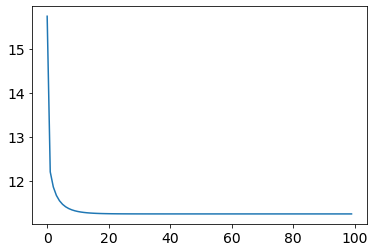

In [ ]:
plt.plot(losses);

In [ ]:
theta

DeviceArray(0.2499989, dtype=float32, weak_type=True)

### Optimization with optax

In [ ]:
theta = 0.5
optimizer = optax.adam(learning_rate=0.01)
state = optimizer.init(theta)

losses = []
for _ in trange(epochs):
    value, grad = value_and_grad_fn(theta, data)
    losses.append(value)
    update, state = optimizer.update(grad, state)
    theta = optax.apply_updates(theta, update)

100%|██████████| 100/100 [00:00<00:00, 434.82it/s]


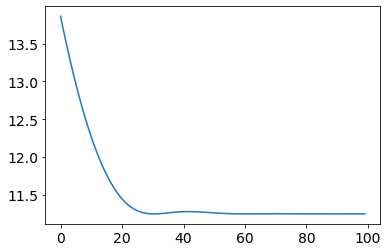

In [ ]:
plt.plot(losses);

In [ ]:
theta

DeviceArray(0.24866374, dtype=float32)

## A debugging tip

### Debug NaNs

In [ ]:
from jax.config import config
config.update("jax_debug_nans", False)

jnp.array(0.0)/jnp.array(0.0)

DeviceArray(nan, dtype=float32, weak_type=True)

In [ ]:
config.update("jax_debug_nans", True)
jnp.array(0.0)/jnp.array(0.0)

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


FloatingPointError: ignored

## Good JAX libraries

* Flax, Haiku - Neural networks in JAX
* NumPyro - Probabilistic programming in JAX
* BlackJAX - MCMC in JAX
* Jraph - Graph neural networks in JAX
* tinygp - Gaussian processes in JAX
* tensorflow_probability.substrates.jax - Power of Tensorflow Probability in JAX